# 🎯 Part 3: Model Evaluation & Analysis

## Mục tiêu
1. Load model đã train và test set
2. Đánh giá model trên test set
3. So sánh metrics train vs test
4. Phân tích Overfitting/Underfitting
5. Đánh giá độ ổn định (stability) của clusters
6. Kết luận và khuyến nghị

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Trained Model & Test Data

In [16]:
# Paths
PROCESSED_DIR = '../data/processed'
MODELS_DIR = '../data/models'

# Load training config
with open(f'{MODELS_DIR}/train_config.json', 'r') as f:
    train_config = json.load(f)

print("📋 TRAINING CONFIGURATION:")
print(json.dumps(train_config, indent=2))

📋 TRAINING CONFIGURATION:
{
  "model_type": "KMeans",
  "n_clusters": 3,
  "coord_weight": 1.0,
  "time_weight": 0.5,
  "feature_columns": [
    "pickup_coordinates_lat",
    "pickup_coordinates_lng",
    "departure_time_minutes"
  ],
  "random_seed": 42,
  "n_init": 20,
  "max_iter": 500,
  "training_metrics": {
    "inertia": 377.17494258296836,
    "silhouette_score": 0.3361919577078005,
    "davies_bouldin_index": 0.9823439640634226,
    "calinski_harabasz_index": 231.81782068951415,
    "n_iterations": 9
  },
  "train_samples": 376,
  "cluster_distribution": {
    "0": 147,
    "1": 95,
    "2": 134
  },
  "trained_date": "2026-01-08T21:26:34.444250"
}


In [17]:
# Load model and scaler
with open(f'{MODELS_DIR}/kmeans_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open(f'{MODELS_DIR}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

cluster_centers = np.load(f'{MODELS_DIR}/cluster_centers.npy')

print("\n✅ MODEL LOADED")
print("=" * 60)
print(f"Model: {train_config['model_type']}")
print(f"Number of clusters: {train_config['n_clusters']}")
print(f"Cluster centers shape: {cluster_centers.shape}")


✅ MODEL LOADED
Model: KMeans
Number of clusters: 3
Cluster centers shape: (3, 3)

Model: KMeans
Number of clusters: 3
Cluster centers shape: (3, 3)


In [18]:
# Load test data
df_test = pd.read_csv(f'{PROCESSED_DIR}/test_data.csv')
X_test = np.load(f'{PROCESSED_DIR}/X_test.npy')

# Load train data for comparison
df_train = pd.read_csv(f'{MODELS_DIR}/train_data_clustered.csv')
X_train = np.load(f'{PROCESSED_DIR}/X_train.npy')

print(f"\n📊 DATA LOADED:")
print(f"   Train samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Feature shape: {X_test.shape}")


📊 DATA LOADED:
   Train samples: 376
   Test samples: 95
   Feature shape: (95, 3)

   Train samples: 376
   Test samples: 95
   Feature shape: (95, 3)


## 2. Predict on Test Set

In [19]:
# Apply same preprocessing as training
COORD_WEIGHT = train_config['coord_weight']
TIME_WEIGHT = train_config['time_weight']

# Scale test data
X_test_scaled = scaler.transform(X_test)  # Use transform, not fit_transform!

# Apply weights
X_test_weighted = X_test_scaled.copy()
X_test_weighted[:, 0] *= COORD_WEIGHT  # lat
X_test_weighted[:, 1] *= COORD_WEIGHT  # lng
X_test_weighted[:, 2] *= TIME_WEIGHT   # time

print("✅ TEST DATA PREPROCESSED")
print("=" * 60)
print(f"Scaled test shape: {X_test_weighted.shape}")
print(f"Mean: {X_test_weighted.mean(axis=0)}")
print(f"Std: {X_test_weighted.std(axis=0)}")

✅ TEST DATA PREPROCESSED
Scaled test shape: (95, 3)
Mean: [ 0.07829598 -0.02895979  0.01232539]
Std: [1.01209153 0.94964514 0.53259039]


In [20]:
# Predict clusters on test set
test_labels = model.predict(X_test_weighted)
df_test['cluster'] = test_labels

print("\n✅ PREDICTIONS COMPLETE")
print("=" * 60)
print(f"Test samples clustered: {len(test_labels)}")
print(f"\n📊 Test Cluster Distribution:")
test_cluster_counts = df_test['cluster'].value_counts().sort_index()
for cluster_id, count in test_cluster_counts.items():
    percentage = count / len(df_test) * 100
    print(f"   Cluster {cluster_id}: {count:3d} customers ({percentage:5.2f}%)")


✅ PREDICTIONS COMPLETE
Test samples clustered: 95

📊 Test Cluster Distribution:
   Cluster 0:  34 customers (35.79%)
   Cluster 1:  31 customers (32.63%)
   Cluster 2:  30 customers (31.58%)


## 3. Calculate Test Metrics

In [21]:
# Calculate metrics on test set
test_silhouette = silhouette_score(X_test_weighted, test_labels)
test_davies_bouldin = davies_bouldin_score(X_test_weighted, test_labels)
test_calinski = calinski_harabasz_score(X_test_weighted, test_labels)

# Calculate inertia manually
distances = cdist(X_test_weighted, model.cluster_centers_, 'euclidean')
min_distances = np.min(distances, axis=1)
test_inertia = np.sum(min_distances ** 2)

print("📊 TEST SET METRICS")
print("=" * 60)
print(f"Inertia: {test_inertia:.2f}")
print(f"Silhouette Score: {test_silhouette:.4f}")
print(f"Davies-Bouldin Index: {test_davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {test_calinski:.2f}")

📊 TEST SET METRICS
Inertia: 100.51
Silhouette Score: 0.2972
Davies-Bouldin Index: 1.1044
Calinski-Harabasz Index: 51.23


## 4. Compare Train vs Test Metrics

### Ngưỡng Đánh Giá:

| Metric | Ideal | Good | Acceptable | Poor |
|--------|-------|------|------------|------|
| **Silhouette Score** | > 0.5 | 0.3 - 0.5 | 0.2 - 0.3 | < 0.2 |
| **Davies-Bouldin** | < 0.5 | 0.5 - 1.0 | 1.0 - 2.0 | > 2.0 |
| **Train-Test Gap** | < 5% | 5% - 10% | 10% - 20% | > 20% |


📊 TRAIN vs TEST COMPARISON
           Metric      Train       Test  Difference    Diff %
          Inertia 377.174943 100.511595  276.663347 73.351465
 Silhouette Score   0.336192   0.297229    0.038963 11.589469
   Davies-Bouldin   0.982344   1.104389    0.122045 12.423819
Calinski-Harabasz 231.817821  51.229002  180.588819 77.901181


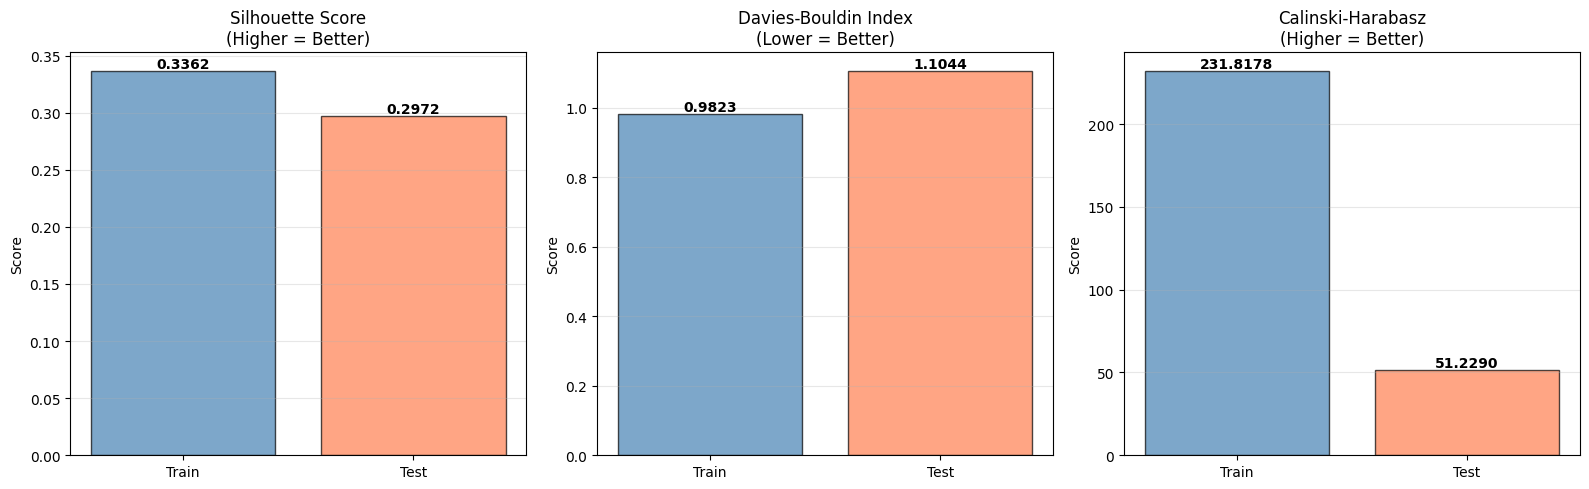

In [22]:
# Get training metrics
train_metrics = train_config['training_metrics']
train_silhouette = train_metrics['silhouette_score']
train_davies_bouldin = train_metrics['davies_bouldin_index']
train_calinski = train_metrics['calinski_harabasz_index']
train_inertia = train_metrics['inertia']

# Calculate differences
sil_diff = abs(test_silhouette - train_silhouette)
sil_diff_pct = (sil_diff / train_silhouette) * 100

db_diff = abs(test_davies_bouldin - train_davies_bouldin)
db_diff_pct = (db_diff / train_davies_bouldin) * 100

cal_diff = abs(test_calinski - train_calinski)
cal_diff_pct = (cal_diff / train_calinski) * 100

inertia_diff = abs(test_inertia - train_inertia)
inertia_diff_pct = (inertia_diff / train_inertia) * 100

# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Inertia', 'Silhouette Score', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'Train': [train_inertia, train_silhouette, train_davies_bouldin, train_calinski],
    'Test': [test_inertia, test_silhouette, test_davies_bouldin, test_calinski],
    'Difference': [inertia_diff, sil_diff, db_diff, cal_diff],
    'Diff %': [inertia_diff_pct, sil_diff_pct, db_diff_pct, cal_diff_pct]
})

print("\n📊 TRAIN vs TEST COMPARISON")
print("=" * 80)
print(comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_to_plot = [
    ('Silhouette Score\n(Higher = Better)', train_silhouette, test_silhouette, 0),
    ('Davies-Bouldin Index\n(Lower = Better)', train_davies_bouldin, test_davies_bouldin, 1),
    ('Calinski-Harabasz\n(Higher = Better)', train_calinski, test_calinski, 2)
]

for title, train_val, test_val, idx in metrics_to_plot:
    x = ['Train', 'Test']
    y = [train_val, test_val]
    colors = ['steelblue', 'coral']
    
    axes[idx].bar(x, y, color=colors, edgecolor='black', alpha=0.7)
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(title)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(y):
        axes[idx].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/train_vs_test_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Overfitting/Underfitting Analysis

In [23]:
def analyze_model_fit(train_sil, test_sil, train_db, test_db, diff_threshold=0.1):
    """
    Analyze if model is overfitting or underfitting
    
    Parameters:
    -----------
    train_sil : float
        Training silhouette score
    test_sil : float
        Test silhouette score
    train_db : float
        Training Davies-Bouldin index
    test_db : float
        Test Davies-Bouldin index
    diff_threshold : float
        Threshold for significant difference (default 10%)
    
    Returns:
    --------
    dict : Analysis results
    """
    results = {
        'status': 'GOOD FIT',
        'confidence': 'HIGH',
        'issues': [],
        'recommendations': []
    }
    
    # Calculate relative differences
    sil_diff_pct = abs(test_sil - train_sil) / train_sil
    db_diff_pct = abs(test_db - train_db) / train_db
    
    # Check silhouette score quality
    if train_sil < 0.2:
        results['status'] = 'UNDERFITTING'
        results['confidence'] = 'LOW'
        results['issues'].append('Very low training Silhouette Score (< 0.2)')
        results['recommendations'].append('Consider increasing k or adjusting feature weights')
    elif train_sil < 0.3:
        results['issues'].append('Low training Silhouette Score (0.2-0.3)')
        results['recommendations'].append('Model quality is acceptable but could be improved')
    
    # Check train-test gap
    if sil_diff_pct > diff_threshold * 2:  # > 20%
        if test_sil < train_sil:
            results['status'] = 'OVERFITTING'
            results['confidence'] = 'MEDIUM'
            results['issues'].append(f'Large Silhouette gap: {sil_diff_pct*100:.1f}% (train > test)')
            results['recommendations'].append('Model may not generalize well to new data')
            results['recommendations'].append('Consider using simpler model or more training data')
    elif sil_diff_pct > diff_threshold:  # 10-20%
        results['confidence'] = 'MEDIUM'
        results['issues'].append(f'Moderate Silhouette gap: {sil_diff_pct*100:.1f}%')
        results['recommendations'].append('Monitor performance on new data')
    
    # Check Davies-Bouldin consistency
    if db_diff_pct > diff_threshold * 2:
        results['issues'].append(f'Large Davies-Bouldin gap: {db_diff_pct*100:.1f}%')
        results['recommendations'].append('Cluster separation varies significantly between train/test')
    
    # Check if test performs better (unusual)
    if test_sil > train_sil * 1.05:  # Test 5% better
        results['issues'].append('Test Silhouette > Train (unusual for clustering)')
        results['recommendations'].append('May indicate lucky split - validate with cross-validation')
    
    # Overall assessment
    if not results['issues']:
        results['recommendations'].append('Model shows good generalization')
        results['recommendations'].append('Proceed with deployment')
    
    return results

# Perform analysis
analysis = analyze_model_fit(
    train_silhouette, test_silhouette,
    train_davies_bouldin, test_davies_bouldin
)

print("\n🔍 MODEL FIT ANALYSIS")
print("=" * 80)
print(f"\n📌 STATUS: {analysis['status']}")
print(f"📌 CONFIDENCE: {analysis['confidence']}")

if analysis['issues']:
    print(f"\n⚠️ ISSUES DETECTED:")
    for i, issue in enumerate(analysis['issues'], 1):
        print(f"   {i}. {issue}")

if analysis['recommendations']:
    print(f"\n💡 RECOMMENDATIONS:")
    for i, rec in enumerate(analysis['recommendations'], 1):
        print(f"   {i}. {rec}")


🔍 MODEL FIT ANALYSIS

📌 STATUS: GOOD FIT
📌 CONFIDENCE: MEDIUM

⚠️ ISSUES DETECTED:
   1. Moderate Silhouette gap: 11.6%

💡 RECOMMENDATIONS:
   1. Monitor performance on new data


## 6. Cluster Stability Analysis

Đánh giá độ ổn định của clusters giữa train và test set


📊 CLUSTER DISTRIBUTION STABILITY

Cluster | Train %  | Test %   | Difference
--------------------------------------------------
   0    |  39.10% |  35.79% |   3.31%
   1    |  25.27% |  32.63% |   7.37%
   2    |  35.64% |  31.58% |   4.06%

Max difference: 7.37%
Avg difference: 4.91%


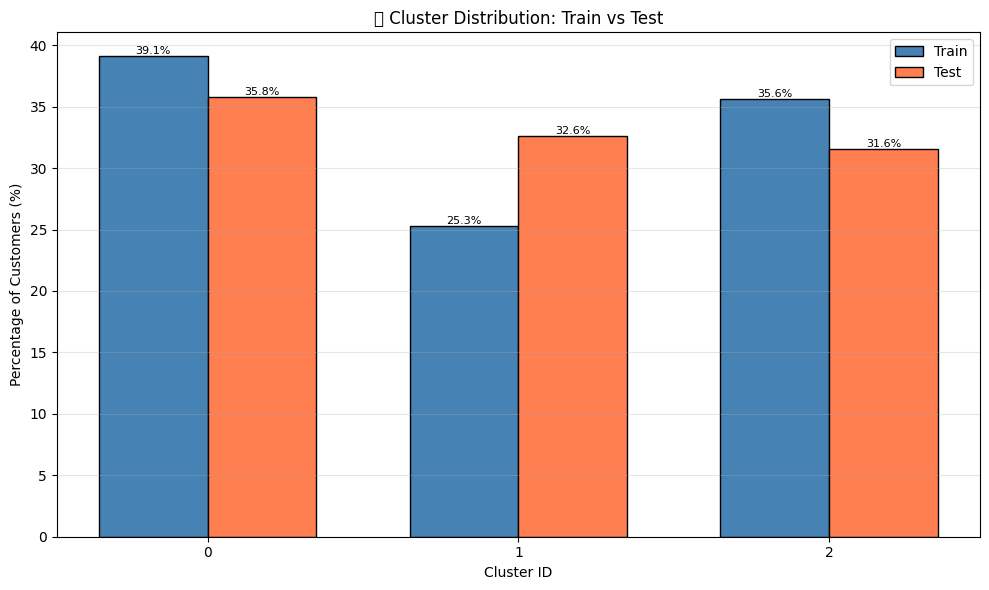


✅ STABILITY: EXCELLENT
   Distributions are very similar


In [24]:
# Compare cluster distributions
train_cluster_counts = df_train['cluster'].value_counts().sort_index()
test_cluster_counts = df_test['cluster'].value_counts().sort_index()

# Normalize to percentages
train_pct = (train_cluster_counts / len(df_train) * 100).values
test_pct = (test_cluster_counts / len(df_test) * 100).values

# Calculate distribution similarity
distribution_diff = np.abs(train_pct - test_pct)
max_diff = np.max(distribution_diff)
avg_diff = np.mean(distribution_diff)

print("\n📊 CLUSTER DISTRIBUTION STABILITY")
print("=" * 80)
print("\nCluster | Train %  | Test %   | Difference")
print("-" * 50)
for i in range(len(train_pct)):
    print(f"   {i}    | {train_pct[i]:6.2f}% | {test_pct[i]:6.2f}% | {distribution_diff[i]:6.2f}%")

print(f"\nMax difference: {max_diff:.2f}%")
print(f"Avg difference: {avg_diff:.2f}%")

# Visualize distribution comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(train_pct))
width = 0.35

bars1 = ax.bar(x - width/2, train_pct, width, label='Train', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_pct, width, label='Test', color='coral', edgecolor='black')

ax.set_xlabel('Cluster ID')
ax.set_ylabel('Percentage of Customers (%)')
ax.set_title('📊 Cluster Distribution: Train vs Test')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../data/cluster_distribution_stability.png', dpi=150, bbox_inches='tight')
plt.show()

# Stability assessment
if avg_diff < 5:
    stability_status = "EXCELLENT"
    stability_desc = "Distributions are very similar"
elif avg_diff < 10:
    stability_status = "GOOD"
    stability_desc = "Minor variations in distribution"
elif avg_diff < 15:
    stability_status = "ACCEPTABLE"
    stability_desc = "Some notable differences in cluster sizes"
else:
    stability_status = "POOR"
    stability_desc = "Significant distribution mismatch"

print(f"\n✅ STABILITY: {stability_status}")
print(f"   {stability_desc}")

## 7. Silhouette Analysis per Cluster


📊 SILHOUETTE ANALYSIS PER CLUSTER (Test Set)

Cluster | Samples | Avg Silhouette | Min    | Max    | Quality
----------------------------------------------------------------------
   0    |    34  |     0.2071    | -0.060 |  0.484 | Fair
   1    |    31  |     0.3607    | -0.039 |  0.570 | Good
   2    |    30  |     0.3339    | -0.005 |  0.518 | Good


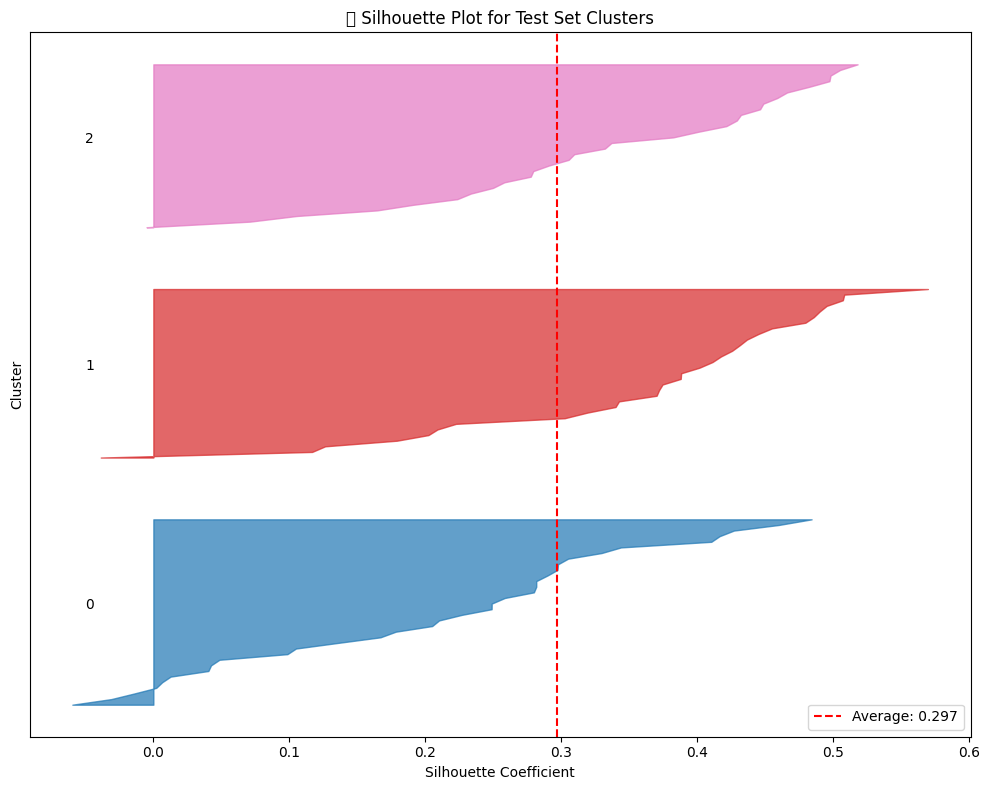

In [25]:
# Calculate silhouette scores for each sample
test_silhouette_samples = silhouette_samples(X_test_weighted, test_labels)

# Analyze per cluster
print("\n📊 SILHOUETTE ANALYSIS PER CLUSTER (Test Set)")
print("=" * 80)
print("\nCluster | Samples | Avg Silhouette | Min    | Max    | Quality")
print("-" * 70)

for cluster_id in range(train_config['n_clusters']):
    cluster_mask = test_labels == cluster_id
    cluster_silhouettes = test_silhouette_samples[cluster_mask]
    
    if len(cluster_silhouettes) > 0:
        avg_sil = cluster_silhouettes.mean()
        min_sil = cluster_silhouettes.min()
        max_sil = cluster_silhouettes.max()
        
        # Quality assessment
        if avg_sil > 0.5:
            quality = "Excellent"
        elif avg_sil > 0.3:
            quality = "Good"
        elif avg_sil > 0.2:
            quality = "Fair"
        else:
            quality = "Poor"
        
        print(f"   {cluster_id}    |  {len(cluster_silhouettes):4d}  |     {avg_sil:6.4f}    | {min_sil:6.3f} | {max_sil:6.3f} | {quality}")

# Visualize silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
for cluster_id in range(train_config['n_clusters']):
    cluster_silhouettes = test_silhouette_samples[test_labels == cluster_id]
    cluster_silhouettes.sort()
    
    size_cluster = cluster_silhouettes.shape[0]
    y_upper = y_lower + size_cluster
    
    color = plt.cm.tab10(cluster_id / train_config['n_clusters'])
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouettes,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_id))
    y_lower = y_upper + 10

ax.set_title('📊 Silhouette Plot for Test Set Clusters')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.axvline(x=test_silhouette, color="red", linestyle="--", label=f'Average: {test_silhouette:.3f}')
ax.set_yticks([])
ax.legend()

plt.tight_layout()
plt.savefig('../data/silhouette_plot_test.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Visualize Test Set Clusters

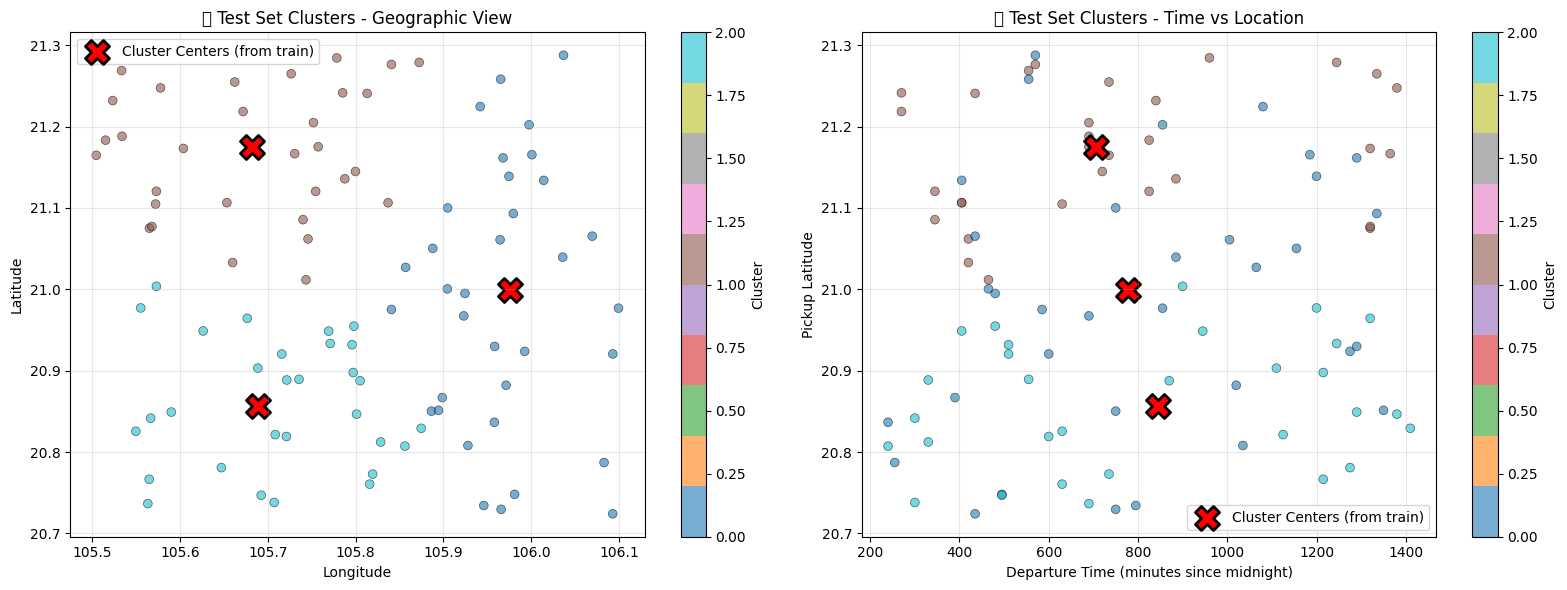

In [26]:
# Visualize test clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Geographic view
scatter1 = axes[0].scatter(
    df_test['pickup_coordinates_lng'],
    df_test['pickup_coordinates_lat'],
    c=df_test['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=40,
    edgecolors='black',
    linewidth=0.5
)

# Plot cluster centers
axes[0].scatter(
    cluster_centers[:, 1],  # lng
    cluster_centers[:, 0],  # lat
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers (from train)'
)

axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'📍 Test Set Clusters - Geographic View')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Time vs Latitude
scatter2 = axes[1].scatter(
    df_test['departure_time_minutes'],
    df_test['pickup_coordinates_lat'],
    c=df_test['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=40,
    edgecolors='black',
    linewidth=0.5
)

axes[1].scatter(
    cluster_centers[:, 2],  # time
    cluster_centers[:, 0],  # lat
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers (from train)'
)

axes[1].set_xlabel('Departure Time (minutes since midnight)')
axes[1].set_ylabel('Pickup Latitude')
axes[1].set_title(f'⏰ Test Set Clusters - Time vs Location')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('../data/test_clusters_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Final Assessment & Recommendations

In [27]:
# Generate comprehensive report
evaluation_report = {
    'model_info': {
        'type': train_config['model_type'],
        'n_clusters': train_config['n_clusters'],
        'coord_weight': train_config['coord_weight'],
        'time_weight': train_config['time_weight']
    },
    'data_split': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'split_ratio': '80/20'
    },
    'metrics': {
        'train': {
            'silhouette_score': float(train_silhouette),
            'davies_bouldin_index': float(train_davies_bouldin),
            'calinski_harabasz_index': float(train_calinski),
            'inertia': float(train_inertia)
        },
        'test': {
            'silhouette_score': float(test_silhouette),
            'davies_bouldin_index': float(test_davies_bouldin),
            'calinski_harabasz_index': float(test_calinski),
            'inertia': float(test_inertia)
        },
        'differences': {
            'silhouette_diff_pct': float(sil_diff_pct),
            'davies_bouldin_diff_pct': float(db_diff_pct),
            'calinski_diff_pct': float(cal_diff_pct)
        }
    },
    'stability': {
        'distribution_max_diff': float(max_diff),
        'distribution_avg_diff': float(avg_diff),
        'status': stability_status
    },
    'model_fit_analysis': analysis,
    'evaluation_date': datetime.now().isoformat()
}

# Save evaluation report
with open(f'{MODELS_DIR}/evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=2)

# Save test predictions
df_test.to_csv(f'{MODELS_DIR}/test_data_clustered.csv', index=False)

print("\n✅ EVALUATION REPORT SAVED")
print("=" * 80)
print(f"Files created:")
print(f"   - {MODELS_DIR}/evaluation_report.json")
print(f"   - {MODELS_DIR}/test_data_clustered.csv")


✅ EVALUATION REPORT SAVED
Files created:
   - ../data/models/evaluation_report.json
   - ../data/models/test_data_clustered.csv


In [28]:
# Display final summary
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                       📊 MODEL EVALUATION SUMMARY                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
""")

print(f"║  MODEL: K-Means with k={train_config['n_clusters']}                                                           ║")
print(f"║  FEATURES: Pickup coordinates + Departure time                               ║")
print(f"║  WEIGHTS: coord={COORD_WEIGHT}, time={TIME_WEIGHT}                                                   ║")
print("║                                                                              ║")
print("║  📊 METRICS COMPARISON:                                                      ║")
print(f"║     Silhouette Score:  Train={train_silhouette:.4f}  Test={test_silhouette:.4f}  Diff={sil_diff_pct:5.1f}%          ║")
print(f"║     Davies-Bouldin:    Train={train_davies_bouldin:.4f}  Test={test_davies_bouldin:.4f}  Diff={db_diff_pct:5.1f}%          ║")
print("║                                                                              ║")
print(f"║  🎯 MODEL STATUS: {analysis['status']:20s}                                    ║")
print(f"║  📊 CONFIDENCE:   {analysis['confidence']:20s}                                    ║")
print(f"║  🔄 STABILITY:    {stability_status:20s}                                    ║")
print("║                                                                              ║")

# Quality assessment
if test_silhouette > 0.5:
    quality_verdict = "EXCELLENT - Clusters are well-separated"
elif test_silhouette > 0.3:
    quality_verdict = "GOOD - Acceptable cluster quality"
elif test_silhouette > 0.2:
    quality_verdict = "FAIR - Clusters have some overlap"
else:
    quality_verdict = "POOR - Weak cluster structure"

print(f"║  ✅ QUALITY: {quality_verdict:55s}║")
print("║                                                                              ║")

if analysis['status'] == 'GOOD FIT':
    print("║  ✅ CONCLUSION:                                                              ║")
    print("║     Model generalizes well to unseen data. Train-test metrics are           ║")
    print("║     consistent, indicating no significant overfitting or underfitting.       ║")
    print("║     Safe to deploy for production use.                                       ║")
elif analysis['status'] == 'OVERFITTING':
    print("║  ⚠️ CONCLUSION:                                                              ║")
    print("║     Model shows signs of OVERFITTING. Performance degrades on test set.     ║")
    print("║     Recommendations: Simplify model or collect more training data.           ║")
elif analysis['status'] == 'UNDERFITTING':
    print("║  ⚠️ CONCLUSION:                                                              ║")
    print("║     Model shows UNDERFITTING. Overall performance is poor.                  ║")
    print("║     Recommendations: Try different k values or adjust feature weights.       ║")

print("║                                                                              ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

# Final recommendations
print("\n💡 RECOMMENDATIONS:")
for i, rec in enumerate(analysis['recommendations'], 1):
    print(f"   {i}. {rec}")

print("\n📁 All evaluation results saved to:", MODELS_DIR)


╔══════════════════════════════════════════════════════════════════════════════╗
║                       📊 MODEL EVALUATION SUMMARY                            ║
╠══════════════════════════════════════════════════════════════════════════════╣

║  MODEL: K-Means with k=3                                                           ║
║  FEATURES: Pickup coordinates + Departure time                               ║
║  WEIGHTS: coord=1.0, time=0.5                                                   ║
║                                                                              ║
║  📊 METRICS COMPARISON:                                                      ║
║     Silhouette Score:  Train=0.3362  Test=0.2972  Diff= 11.6%          ║
║     Davies-Bouldin:    Train=0.9823  Test=1.1044  Diff= 12.4%          ║
║                                                                              ║
║  🎯 MODEL STATUS: GOOD FIT                                                ║
║  📊 CONFIDENCE:   MEDIUM          

## Summary

✅ **Evaluation completed:**
1. Tested model on unseen data (20% test set)
2. Calculated comprehensive metrics
3. Compared train vs test performance
4. Analyzed overfitting/underfitting
5. Assessed cluster stability
6. Generated final evaluation report

**Files generated:**
- `evaluation_report.json` - Complete evaluation metrics
- `test_data_clustered.csv` - Test data with predictions
- Multiple visualization plots

**Next steps:**
- If model is satisfactory → Deploy to production
- If overfitting detected → Retrain with more data or simpler model
- If underfitting → Adjust hyperparameters and retrain